In [1]:
import torch
from torch import nn
from torch_geometric.data import Data, Batch
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from directions import generate_uniform_2d_directions
from wect import ECTLayer, ECTConfig
DEVICE = "cpu"

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

# Preprocess the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [3]:
# Create PyTorch geometric batch
train_data = [Data(x=X_train[i:i+1, :2]) for i in range(len(X_train))]
train_batch = Batch.from_data_list(train_data)

test_data = [Data(x=X_test[i:i+1, :2]) for i in range(len(X_test))]
test_batch = Batch.from_data_list(test_data)

In [4]:
# Define the classification model
class ECTClassifier(nn.Module):
    def __init__(self, ect_config, directions, input_dim, hidden_dim, output_dim):
        super(ECTClassifier, self).__init__()
        self.ect_layer = ECTLayer(ect_config, v=directions)
        # Adjust input_dim of fc1 to match flattened size
        self.fc1 = nn.Linear(128 * 128, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, batch):
        ect_features = self.ect_layer(batch)
        # Flatten the output of ECTLayer
        ect_features = ect_features.view(ect_features.size(0), -1)  # (batch_size, 128 * 128)
        out = self.relu(self.fc1(ect_features))
        out = self.fc2(out)
        return out


# Set directions and configurations
num_thetas = 128
v = torch.vstack(
    [
        torch.sin(torch.linspace(0, torch.pi, num_thetas)),
        torch.cos(torch.linspace(0, torch.pi, num_thetas)),
    ]
)

ect_config = ECTConfig(
    ect_type="points",
    bump_steps=128,
    radius=1.0,
    normalized=False,
    fixed=True,
)

# Instantiate the model
model = ECTClassifier(
    ect_config=ect_config,
    directions=v,
    input_dim=4,
    hidden_dim=64,
    output_dim=len(np.unique(y_train)),
).to(DEVICE)

In [5]:
# Training the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(train_batch.to(DEVICE))
    loss = criterion(outputs, y_train.to(DEVICE))
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(test_batch.to(DEVICE))
    predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
    accuracy = accuracy_score(y_test.numpy(), predicted_labels)

print(f"Test Accuracy: {accuracy:.2%}")

AttributeError: 'GlobalStorage' object has no attribute 'node_weights'

## SVM with RBF and DECT

c:\Users\Keshav Chandak\OneDrive\Desktop\semester 8\Topo_PE\DECT ML Code\.venv\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\Keshav Chandak\OneDrive\Desktop\semester 8\Topo_PE\DECT ML Code\.venv\Lib\site-packages\torch_scatter\_scatter_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


Test Accuracy: 100.00%
DECT Loss: 0.3336


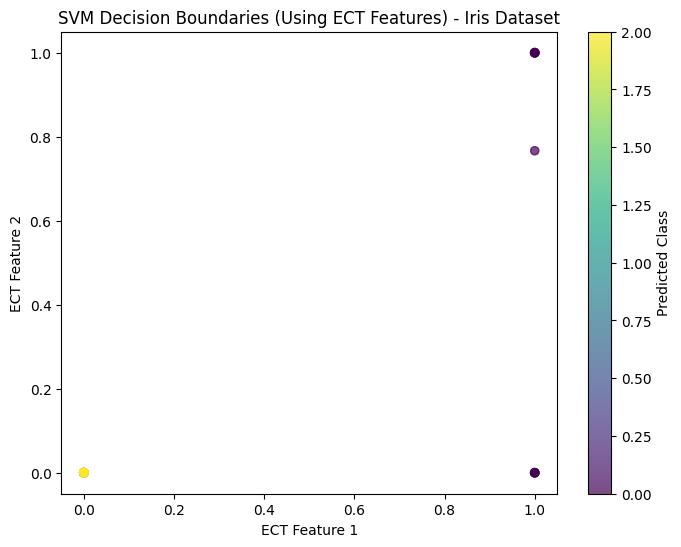

In [ ]:
import torch
from torch import nn
from torch_geometric.data import Data, Batch
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from ect import ECTLayer, ECTConfig

DEVICE = "cpu"

# Load Iris dataset
def load_iris_data():
    iris = load_iris()
    X, y = iris.data, iris.target
    return X, y

# Define RBF kernel function
def rbf_kernel(x1, x2, gamma=1.0):
    distance = torch.cdist(x1, x2, p=2)
    return torch.exp(-gamma * distance ** 2)

# Custom DECT loss using RBF kernel
class DECTLoss(nn.Module):
    def __init__(self, gamma=1.0):
        super(DECTLoss, self).__init__()
        self.gamma = gamma

    def forward(self, ect_features, labels):
        kernel_matrix = rbf_kernel(ect_features, ect_features, self.gamma)
        margins = torch.matmul(kernel_matrix, labels.float())
        loss = torch.mean(torch.clamp(1 - margins, min=0))
        return loss

# Define a feature extractor with ECT
class ECTFeatureExtractor(nn.Module):
    def __init__(self, ect_config, directions, input_dim, hidden_dim=128):
        super(ECTFeatureExtractor, self).__init__()
        self.projection = nn.Linear(input_dim, hidden_dim)  # Map 4D → 128D
        self.ect_layer = ECTLayer(ect_config, v=directions)

    def forward(self, batch):
        projected_features = self.projection(batch.x)  # Project to 128D
        ect_features = self.ect_layer(batch)
        return ect_features

# Set directions and configurations
num_features = 4  # Iris dataset has 4 features
num_thetas = 128
v = torch.randn(num_features, num_thetas)  # Random projections in 4D

ect_config = ECTConfig(
    ect_type="points",
    bump_steps=128,
    radius=1.0,
    normalized=False,
    fixed=True,
)

# Load and preprocess Iris dataset
X, y = load_iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Convert dataset to PyTorch Geometric format
train_data = [Data(x=X_train[i:i+1]) for i in range(len(X_train))]
train_batch = Batch.from_data_list(train_data)

test_data = [Data(x=X_test[i:i+1]) for i in range(len(X_test))]
test_batch = Batch.from_data_list(test_data)

# Extract ECT features
ect_extractor = ECTFeatureExtractor(ect_config=ect_config, directions=v, input_dim=num_features).to(DEVICE)
ect_features_train = ect_extractor(train_batch.to(DEVICE)).detach().cpu().numpy().reshape(len(y_train), -1)
ect_features_test = ect_extractor(test_batch.to(DEVICE)).detach().cpu().numpy().reshape(len(y_test), -1)

# Train SVM model with RBF kernel
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale")
svm_model.fit(ect_features_train, y_train.numpy())

# Get SVM predictions
predicted_labels = svm_model.predict(ect_features_test)
accuracy = accuracy_score(y_test.numpy(), predicted_labels)
print(f"Test Accuracy: {accuracy:.2%}")

# Compute DECT loss
dect_loss_fn = DECTLoss(gamma=1.0)
dect_loss = dect_loss_fn(torch.tensor(ect_features_train), y_train)
print(f"DECT Loss: {dect_loss.item():.4f}")

# Plot decision boundaries (optional)
plt.figure(figsize=(8, 6))
plt.scatter(ect_features_test[:, 0], ect_features_test[:, 1], c=predicted_labels, cmap="viridis", alpha=0.7)
plt.title("SVM Decision Boundaries (Using ECT Features) - Iris Dataset")
plt.xlabel("ECT Feature 1")
plt.ylabel("ECT Feature 2")
plt.colorbar(label="Predicted Class")
plt.show()


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl (11.5 MB)
Test Accuracy: 75.00%
DECT Loss: 0.5471


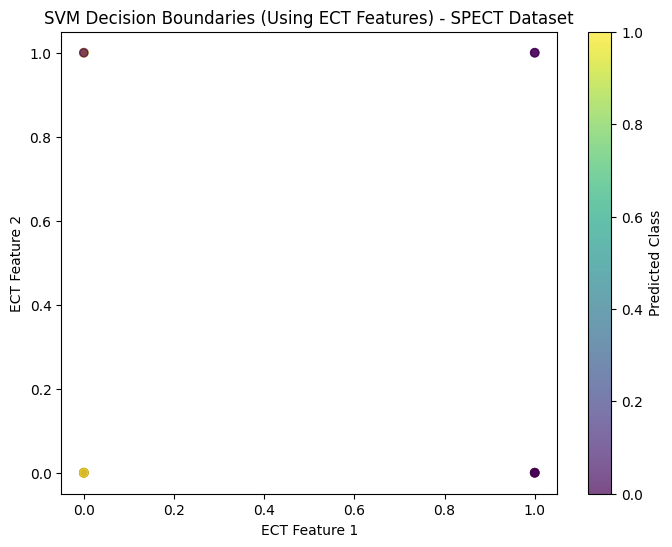

In [ ]:
w